# Root Finding

Root finding is the problem of solving nonlinear equations.

Learning objectives:
 - bisection method
 - secant method and inverse quadratic interpolation
 - MATLAB function `fzero`

## Finding Roots Algebraically

It is easy to solve a quadratic equation using the quadratic formula by hand. For low-degree polynomials, we can do it using a computer algebraic system, such as the Symbolic toolkit.

In [1]:
% Initialize the Octave symbolic package. Not needed in MATLAB
pkg load symbolic;
sym;

OctSymPy v2.5.0: this is free software without warranty, see source.
Initializing communication with SymPy using a popen2() pipe.
Some output from the Python subprocess (pid 205) might appear next.
Python 2.7.12 (default, Nov 19 2016, 06:48:10) 
[GCC 5.4.0 20160609] on linux2
Type "help", "copyright", "credits" or "license" for more information.
>>> >>> 
OctSymPy: Communication established.  SymPy v1.0.


In [2]:
% Construct a general quadratic equation
syms a b c x

P = a*x^2 + b*x + c;
pretty(P)

     2          
  a⋅x  + b⋅x + c


In [3]:
% Solve it algebraically
pretty(simplify(solve(P == 0, x)))

  ⎡ ⎛       _____________⎞ ⎤
  ⎢ ⎜      ╱           2 ⎟ ⎥
  ⎢-⎝b + ╲╱  -4⋅a⋅c + b  ⎠ ⎥
  ⎢────────────────────────⎥
  ⎢          2⋅a           ⎥
  ⎢                        ⎥
  ⎢         _____________  ⎥
  ⎢        ╱           2   ⎥
  ⎢ -b + ╲╱  -4⋅a⋅c + b    ⎥
  ⎢ ─────────────────────  ⎥
  ⎣          2⋅a           ⎦


We can also solve cubic equations algebraically.

In [4]:
P = 2*x^3 - 3*x^2 - 11 * x - 6;
pretty(P)

     3      2           
  2⋅x  - 3⋅x  - 11⋅x - 6


In [5]:
pretty(solve(P==0, x))

  ⎡   -1    ⎤
  ⎢         ⎥
  ⎢ 5   √73 ⎥
  ⎢ ─ + ─── ⎥
  ⎢ 4    4  ⎥
  ⎢         ⎥
  ⎢  √73   5⎥
  ⎢- ─── + ─⎥
  ⎣   4    4⎦


The roots are the intersections of the graph of the function with the $x$ axis.

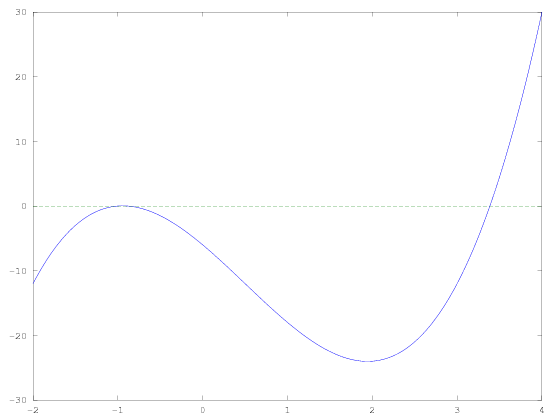

In [6]:
xs = -2:0.01:4;
plot(xs, 2*xs.^3 - 3*xs.^2 - 11 * xs - 6, '-', [-2,4], zeros(2,1), '--')

However, our luck runs out pretty quickly. Symbolic packages cannot find a root for the following problem:

In [7]:
P = 2*x^6 - 3*x^2 - 11 * x - 6;
pretty(P)

     6      2           
  2⋅x  - 3⋅x  - 11⋅x - 6


In [8]:
solve(P == 0, x)

ans = {}(0x0)


This is not a bug in the symbolic packages. It was proven by Niels Henrik Abel in 1824 that there is no algebraic solution — that is, solution in radicals — to the general polynomial equations of degree five or higher with arbitrary coefficients.

However, there is clearly a solution between -1 and 0, and we can find it using numerical methods.

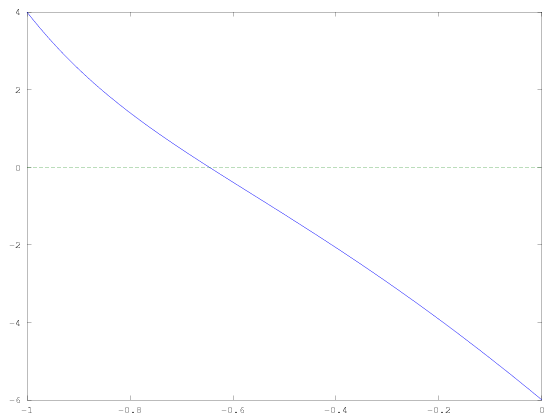

In [9]:
xs = -1:0.01:0;
plot(xs, 2*xs.^6 - 3*xs.^2 - 11 * xs - 6, '-', [-1,0], zeros(2,1), '--');

## Bisection Method

The bisection method begins with an initial bracket and repeatedly halves its length until the solution has been isolated as accurately as desired.

In [10]:
%bisection method for solving 2*x^6 - 3*x^2 - 11 * x - 6 = 0

a = -1;
b = 0;
k = 0;

tol = 1e-3

while b-a > tol
    x = (a + b) / 2;
    % Here, we always have func(a)>=0 and func(b)<0
    if 2*x^6 - 3*x^2 - 11 * x - 6 < 0
        b = x;
    else
        a = x;
    end
    k = k + 1;

    fprintf('k = %2d, a = %.10f, b = %.10f, (b-a)=%.10f\n', k, a, b, b-a);
end

fprintf('x = %.16g after %d iterations\n', x, k);

tol =  0.0010000
k =  1, a = -1.0000000000, b = -0.5000000000, (b-a)=0.5000000000
k =  2, a = -0.7500000000, b = -0.5000000000, (b-a)=0.2500000000
k =  3, a = -0.7500000000, b = -0.6250000000, (b-a)=0.1250000000
k =  4, a = -0.6875000000, b = -0.6250000000, (b-a)=0.0625000000
k =  5, a = -0.6562500000, b = -0.6250000000, (b-a)=0.0312500000
k =  6, a = -0.6562500000, b = -0.6406250000, (b-a)=0.0156250000
k =  7, a = -0.6484375000, b = -0.6406250000, (b-a)=0.0078125000
k =  8, a = -0.6484375000, b = -0.6445312500, (b-a)=0.0039062500
k =  9, a = -0.6464843750, b = -0.6445312500, (b-a)=0.0019531250
k = 10, a = -0.6464843750, b = -0.6455078125, (b-a)=0.0009765625
x = -0.6455078125 after 10 iterations


The above example is specialized to the example function. To make the method applicable to functions, we can define a MATLAB function, which takes a [function handle](https://www.mathworks.com/help/matlab/matlab_prog/creating-a-function-handle.html) as an input argument.

In [11]:
function [x, k] = bisect(f, a, b, tol)
% BISECT finds a root of f(x) within the interval [a,b] 
% using the bisection method. It assumes f(a) and f(b) have 
% opposite signs.

k = 0;
fb = f(b); s = sign(fb);

if nargin<4; tol = eps*abs(b-a); end

while b-a > tol
    x = (a + b)/2;
    if sign(f(x)) == s
        b = x;
    else
        a = x;
    end
    k = k + 1;
end
end

In MATLAB, you need to save the above function definition into an M-file named `bisect.m`. 

To call `bisect`, we can use [anonymous functions](https://www.mathworks.com/help/matlab/matlab_prog/anonymous-functions.html), which are similar to the [lambda functions in Python](https://docs.python.org/3/tutorial/controlflow.html#lambda-expressions).

In [12]:
% We define an anonymous function
f = @(x) 2*x^6 - 3*x^2 - 11 * x - 6;

[x, k] = bisect(f, -1, 0);
fprintf('x=%.16g after %d iterations, and f(x) is %.16g\n', x, k, f(x));

x=-0.6460701696247522 after 52 iterations, and f(x) is -1.77635683940025e-15


In [13]:
% We can also use function handles to regular functions
f = @sin;
[x, k] = bisect(f, -1, 1);
fprintf('x=%.16g after %d iterations, and f(x) is %.16g\n', x, k, f(x));

x=4.440892098500626e-16 after 52 iterations, and f(x) is 4.440892098500626e-16


Bisection is completely reliable, as long as $f(a)$ and $f(b)$ have opposite signs. However, it is quite slow. With the termination condition in the above code, it always takes 52 steps for any function to reach machine precision when using double-precision floating-point numbers.

## Secant Method

Similar to the bisection method, the secant method uses two data points to determine a third one at each step. However, it uses not only the signs but also the values to draw a secant line through two points.
<img src="https://drive.google.com/uc?export=download&id=0ByTwsK5_Tl_Pc2gtOGtjNXYzY2s" width="400">

The slope of the scant is given by
$$s_k = \frac{f(x_k)-f(x_{k-1})}{x_k-x_{k-1}}.$$
The intersection of the secant with the $x$ axis is then
$$x_{k+1} = x_k - \frac{f(x_k)}{s_k} = x_k + \frac{x_k-x_{k-1}}{f(x_{k-1}) / f(x_k) - 1}.$$

The secant method can be implemented as follows:

In [14]:
function [x, k] = secant(f, ab, tol)
% SECANT finds a root of f(x) using the secant method.

if nargin<3; tol = eps; end

a = ab(1); b = ab(2);
maxiter = 100;
fa = f(a);

for k = 1:maxiter
    % x = b + (b - a)/(f(a)/f(b)-1);
    % a = b; 
    % b = x;

    fb = f(b);
    if fb == 0; x = b; break; end
    delta = (b - a)/(fa/fb-1);
    x = b + delta;

    if abs(delta) <= tol*abs(b)
        break;
    end

    a = b; fa = fb;
    b = x;
end
end

In MATLAB, you need to save the above function definition into an M-file named `secant.m`.

In [15]:
f = @(x) 2*x^6 - 3*x^2 - 11 * x - 6;

[x, k] = secant(f, [-1, 0]);
fprintf('x=%.16g after %d iterations, and f(x) is %.16g\n', x, k, f(x));

x=-0.6460701696247523 after 7 iterations, and f(x) is 0


Note that we may get different answers with different starting points.

In [16]:
[x, k] = secant(f, [1, 2]);
fprintf('x=%.16g after %d iterations, and f(x) is %.16g\n', x, k, f(x));

x=1.577469571234518 after 14 iterations, and f(x) is -1.4210854715202e-14


Here is another example.

In [17]:
f = @sin;
[x, k] = secant(f, [-1, 0.4]);
fprintf('x=%.16g after %d iterations, and f(x) is %.16g\n', x, k, f(x));

x=0 after 7 iterations, and f(x) is 0


The secant method is faster than the bisection method. However, it is less reliable and may fail to converge to a solution.

The secant method is also closely related to *Newton’s method*, in which
$$x_{k+1} = x_k - \frac{f(x_k)}{f'(x_k)}.$$
<img src="https://drive.google.com/uc?export=download&id=0ByTwsK5_Tl_PR21qYmZrN3d0bzg" width="300">
The secant method can be interpreted as using a finite difference approximation to estimate the derivative in Newton's method.

The secant method may take more iterations to converge than Newton's method, but it is more efficient per iteration, so in general the secant method is preferred over Newton's method.

## Inverse Quadratic Interpolation

The secant method uses two points to construct a linear polynomial to approximate the function locally. 

We can use more points to construct higher-degree interpolating polynomials, such as quadratic polynomials, and compute its intersection with the $x$ axis. However, this idea is problematic because a parabola may have zero, one or two intersections with the $x$ axis.

The problem can be fixed by constructing a quadratic interpolation of $x$ as a function of $y$. This is a "sideways" parabola, and it is guaranteed to intersect the $x$ axis exactly once. This is known as *inverse quadratic interpolation* (IQI).

<img src="https://drive.google.com/uc?export=download&id=0ByTwsK5_Tl_PbTJIYVppdU1PRW8" width="400">


The following is a high-level MATLAB implementation to illustrate the idea.

In [18]:
function [x, k] = iqi(f, abc)
% IQI finds a root of f(x) using the inverse quadratic interpolation.

a = abc(1); b = abc(2); c = abc(3);
maxiter = 100;

for k = 1:maxiter
    x = polyval(polyfit([f(a),f(b),f(c)],[a,b,c], 2), 0);
    a = b;
    b = c;
    c = x;

    if abs(c-b) <= eps*abs(c)
        break;
    end
end
end

In MATLAB, you need to save the above function definition into an M-file named `iqi.m`.

In [19]:
f = @(x) 2*x^6 - 3*x^2 - 11 * x - 6;

[x, k] = iqi(f, [-1, 0.5, 0]);
fprintf('x=%.16g after %d iterations, and f(x) is %.16g\n', x, k, f(x));

x=-0.6460701696247524 after 6 iterations, and f(x) is 0


Similarly, one can also use inverse cubic interpolation (ICI).

Like the secant method, IQI and ICI may both fail to converge.

## Hybrid Method for Efficiency and Robustness 

Bisection method is robust but slow, and IQI, ICI etc. are faster but less robust. It is a good idea to combine them together to deliver both efficiency and robustness. This is the idea behind the `fzero` function in MATLAB. The following is a simplified implementation.

In [20]:
function b = fzerotx(F,ab,varargin)
%FZEROTX  Textbook version of FZERO.
%   x = fzerotx(F,[a,b]) tries to find a zero of F(x) between a and b.
%   F(a) and F(b) must have opposite signs.  fzerotx returns one 
%   end point of a small subinterval of [a,b] where F changes sign.
%   Arguments beyond the first two, fzerotx(F,[a,b],p1,p2,...),
%   are passed on, F(x,p1,p2,..).
%
%   Examples:
%      fzerotx(@sin,[1,4])
%      F = @(x) sin(x); fzerotx(F,[1,4])

%   Copyright 2014 Cleve Moler
%   Copyright 2014 The MathWorks, Inc.

%% The first section of code initializes the variables a, b, and c 
%% that characterize the search interval. The function F is evaluated 
%% at the endpoints of the initial interval.
% Initialize.
a = ab(1);
b = ab(2);
fa = F(a,varargin{:});
fb = F(b,varargin{:});
if sign(fa) == sign(fb)
   error('Function must change sign on the interval')
end
c = a;
fc = fa;
d = b - c;
e = d;

%% Here is the beginning of the main loop. At the start of each pass 
%% through the loop, a, b, and c are rearranged so that f(a) and f(b)
%% have opposite signs, |f(b)| <= |f(a)|, and c is the previous value of b.
while fb ~= 0

   % The three current points, a, b, and c, satisfy:
   %    f(x) changes sign between a and b.
   %    abs(f(b)) <= abs(f(a)).
   %    c = previous b, so c might = a.
   % The next point is chosen from
   %    Bisection point, (a+b)/2.
   %    Secant point determined by b and c.
   %    Inverse quadratic interpolation point determined
   %    by a, b, and c if they are distinct.

   if sign(fa) == sign(fb)
      a = c;  fa = fc;
      d = b - c;  e = d;
   end
   if abs(fa) < abs(fb)
      c = b;    b = a;    a = c;
      fc = fb;  fb = fa;  fa = fc;
   end
   
   % Convergence test and possible exit
   m = 0.5*(a - b);
   tol = 2.0*eps*max(abs(b),1.0);
   if (abs(m) <= tol) | (fb == 0.0)
      break
   end
   
   % Choose bisection or interpolation
   if (abs(e) < tol) | (abs(fc) <= abs(fb))
      % Bisection
      d = m;
      e = m;
   else
      % Interpolation
      s = fb/fc;
      if (a == c)
         % Linear interpolation (secant)
         p = 2.0*m*s;
         q = 1.0 - s;
      else
         % Inverse quadratic interpolation
         q = fc/fa;
         r = fb/fa;
         p = s*(2.0*m*q*(q - r) - (b - c)*(r - 1.0));
         q = (q - 1.0)*(r - 1.0)*(s - 1.0);
      end;
      if p > 0, q = -q; else p = -p; end;
      % Is interpolated point acceptable
      if (2.0*p < 3.0*m*q - abs(tol*q)) & (p < abs(0.5*e*q))
         e = d;
         d = p/q;
      else
         d = m;
         e = m;
      end;
   end
   
   % Next point
   %% The final section evaluates F at the next iterate.
   c = b;
   fc = fb;
   if abs(d) > tol
      b = b + d;
   else
      b = b - sign(b-a)*tol;
   end
   fb = F(b,varargin{:});
end
end

In MATLAB, you need to save the above function definition into an M-file named `fzerotx.m`.

In [21]:
f = @(x) 2*x^6 - 3*x^2 - 11 * x - 6;

x = fzerotx(f, [-1, 0]);
fprintf('x=%.16g and f(x) is %.16g\n', x, f(x));

x=-0.6460701696247524 and f(x) is 0


Acknowledgment: The material in this Notebook was adapted from Chapter 4 of Numerical Computing with MATLAB by Cleve Moler, 2004.